In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.layers import Input, DepthwiseConv2D
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, AvgPool2D, Flatten, Dense
from tensorflow.keras import Model
import distiller_trainer as dt

# Creating the Teacher (MobileNet)

In [2]:
def mobilnet_block (x, filters, strides):
    
    x = DepthwiseConv2D(kernel_size = 3, strides = strides, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filters = filters, kernel_size = 1, strides = 1)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    return x
#stem of the model
input = Input(shape = (28,28,1))
x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)
# main part of the model
x = mobilnet_block(x, filters = 64, strides = 1)
x = mobilnet_block(x, filters = 128, strides = 2)
x = mobilnet_block(x, filters = 128, strides = 1)
x = mobilnet_block(x, filters = 256, strides = 2)
x = mobilnet_block(x, filters = 256, strides = 1)
x = mobilnet_block(x, filters = 512, strides = 2)
for _ in range (5):
     x = mobilnet_block(x, filters = 512, strides = 1)
x = mobilnet_block(x, filters = 1024, strides = 2)
x = mobilnet_block(x, filters = 1024, strides = 1)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = Dense (units = 10, activation = 'softmax')(x)
teacher = Model(inputs=input, outputs=output)
teacher.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 14, 14, 32)        0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 14, 14, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 32)        0     

# Creating the Student Network (a simple sequential CNN)

In [3]:
student = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(10),
    ],
    name="student",
)

student_scratch = keras.models.clone_model(student)

# Preparing the dataset

In [4]:
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))

In [5]:
x_train = x_train[:10000]
y_train = y_train[:10000]

In [6]:
x_test = x_test[:2000]
y_test = y_test[:2000]

# Training the Teacher

In [7]:
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate teacher on data.
teacher.fit(x_train, y_train, epochs=5)
teacher.evaluate(x_test, y_test)

Epoch 1/5


/home/ecbm4040/envTF24/lib/python3.6/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


313/313 [==============================] - 52s 161ms/step - loss: 1.3598 - sparse_categorical_accuracy: 0.5606
Epoch 2/5
313/313 [==============================] - 50s 160ms/step - loss: 0.4679 - sparse_categorical_accuracy: 0.8523
Epoch 3/5
313/313 [==============================] - 50s 158ms/step - loss: 0.2982 - sparse_categorical_accuracy: 0.9067
Epoch 4/5
313/313 [==============================] - 49s 158ms/step - loss: 0.2260 - sparse_categorical_accuracy: 0.9305
Epoch 5/5
63/63 [==============================] - 1s 15ms/step - loss: 0.4126 - sparse_categorical_accuracy: 0.8870


[0.41262179613113403, 0.8870000243186951]

# Distilling the teacher to the student

In [14]:
# Initialize and compile distiller
distiller = dt.Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
dist_history = distiller.fit(x_train, y_train, epochs=3)

# Evaluate student on test dataset
distiller.evaluate(x_test, y_test)

Epoch 1/3
313/313 [==============================] - 6s 17ms/step - sparse_categorical_accuracy: 0.9601 - student_loss: 1.2542 - distillation_loss: 0.0315
Epoch 2/3
313/313 [==============================] - 5s 17ms/step - sparse_categorical_accuracy: 0.9629 - student_loss: 1.2419 - distillation_loss: 0.0313
Epoch 3/3
63/63 [==============================] - 0s 2ms/step - sparse_categorical_accuracy: 0.9530 - student_loss: 1.2812


[0.953000009059906, 1.2237679958343506]

# Training Student from scratch to compare performance

In [15]:
# Train student as doen usually
student_scratch.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate student trained from scratch.
stud_history = student_scratch.fit(x_train, y_train, epochs=3)
student_scratch.evaluate(x_test, y_test)

Epoch 1/3
313/313 [==============================] - 1s 4ms/step - loss: 0.1132 - sparse_categorical_accuracy: 0.9654
Epoch 2/3
313/313 [==============================] - 1s 4ms/step - loss: 0.0921 - sparse_categorical_accuracy: 0.9717
Epoch 3/3
63/63 [==============================] - 0s 2ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.9620


[0.12380778789520264, 0.9620000123977661]

In [17]:
stud_history.history

{'loss': [0.11315357685089111, 0.09214413911104202, 0.07667796313762665],
 'sparse_categorical_accuracy': [0.965399980545044,
  0.9717000126838684,
  0.9767000079154968]}

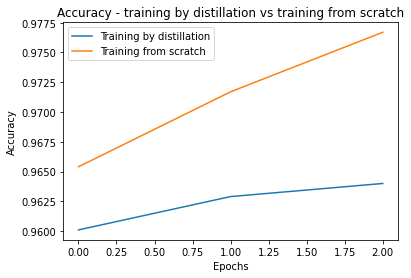

In [20]:
import matplotlib.pyplot as plt
plt.subplot()
plt.title('Accuracy - training by distillation vs training from scratch')
plt.plot([val for val in dist_history.history['sparse_categorical_accuracy']])
plt.plot([val for val in stud_history.history['sparse_categorical_accuracy']])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training by distillation','Training from scratch'])
plt.show()